In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
from pathlib import Path

🌱 SEMANTIC CLIMATE VARIABLES DATASET ANALYSIS
📊 Dataset shape: (82348, 70)
📅 Time period: 2009-2025
🏢 Number of firms: 1210
⏰ Number of quarters: 68

📈 DATA COVERAGE:
  Total possible firm-quarters: 82,348
  Firm-quarters with earnings calls: 28,008
  Coverage rate: 34.0%

🔍 CLIMATE TOPIC VARIABLES:
  Climate topics: 5
  Policy topics: 6

📋 TOPIC COVERAGE (% firm-quarters with mentions):
  opportunities  :   8.6% coverage, 0.0230 mean exposure
  regulation     :   1.5% coverage, 0.0026 mean exposure
  physical_risk  :   1.9% coverage, 0.0032 mean exposure
  transition_risk:   3.0% coverage, 0.0055 mean exposure
  disclosure     :   2.6% coverage, 0.0050 mean exposure


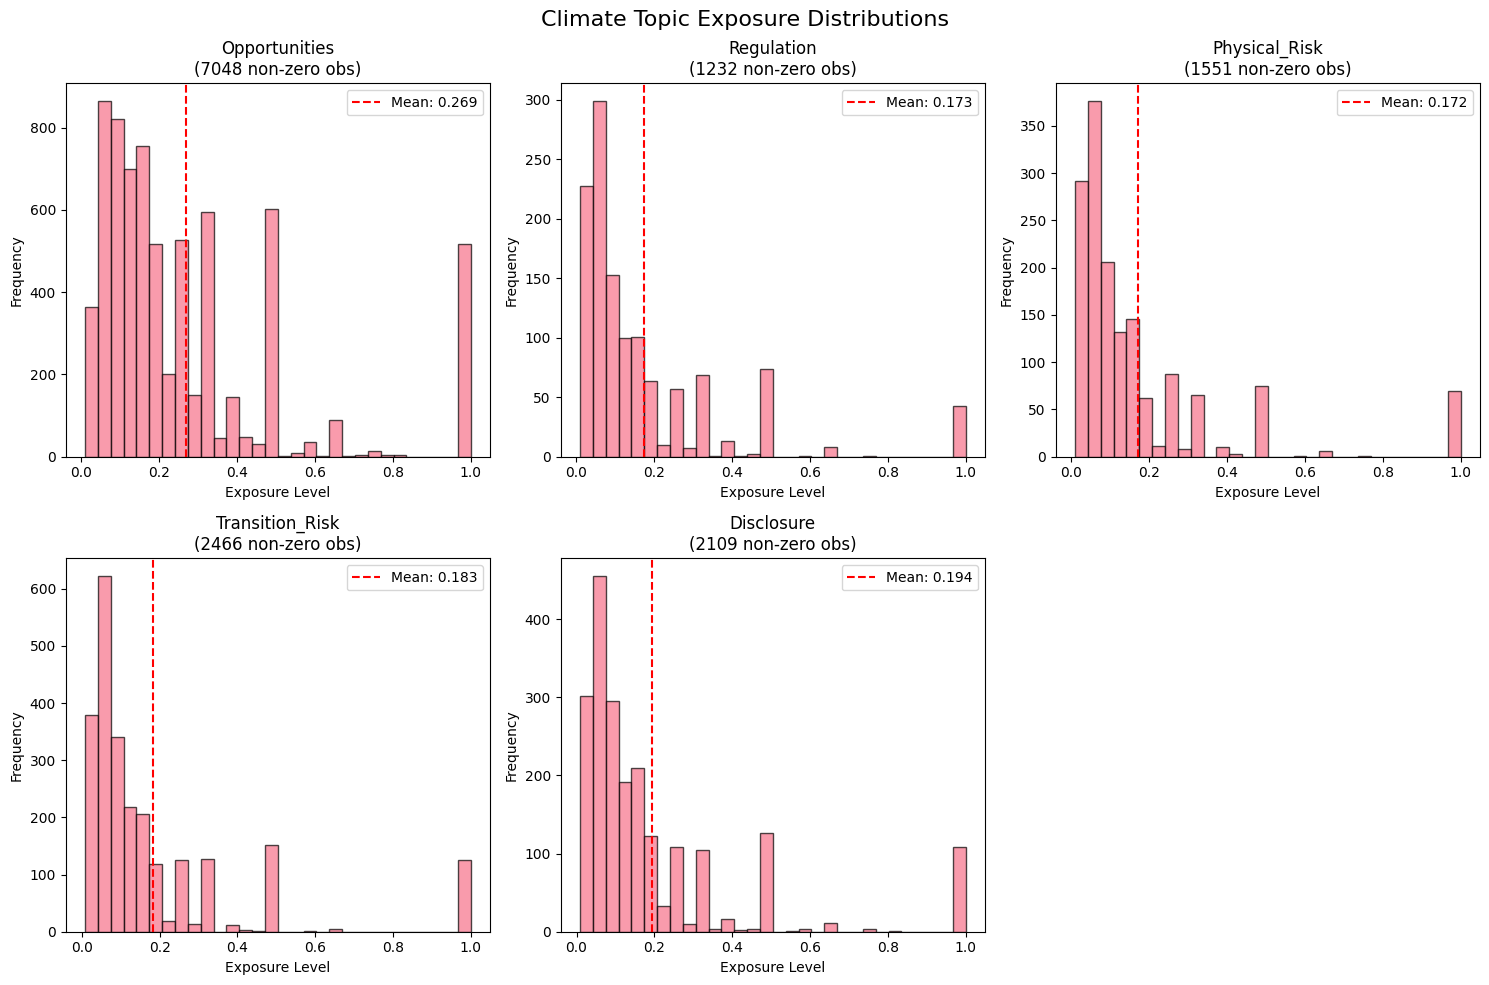


📈 TIME TRENDS ANALYSIS:


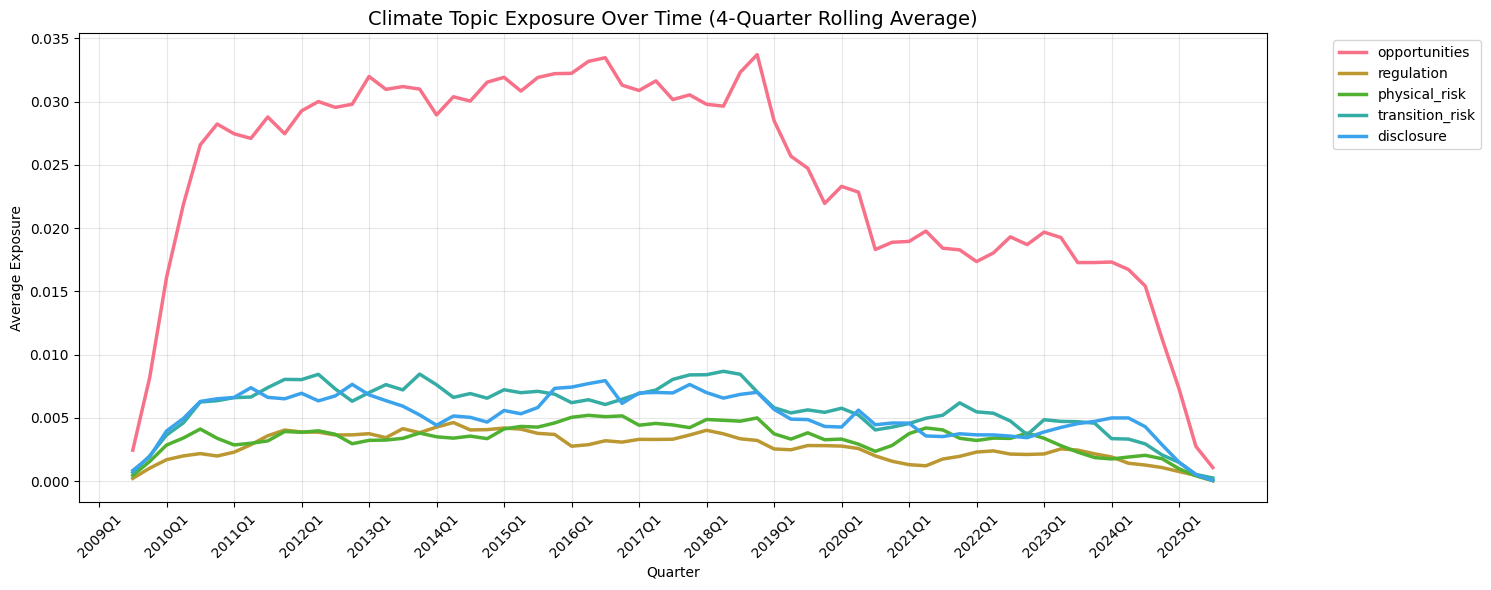


📊 SMOOTHING INFO:
Applied 4-quarter rolling average to smooth time series
Showing climate topic exposure trends only

🏢 CROSS-SECTIONAL ANALYSIS:

🏆 TOP 10 FIRMS BY TOTAL CLIMATE EXPOSURE:
   1. TRMB   - 0.3671
   2. OXY    - 0.2649
   3. WAT    - 0.2567
   4. PPL    - 0.2493
   5. FE     - 0.2483
   6. CAT    - 0.2441
   7. WM     - 0.2417
   8. DE     - 0.2394
   9. CCL    - 0.2261
  10. CUK    - 0.2237


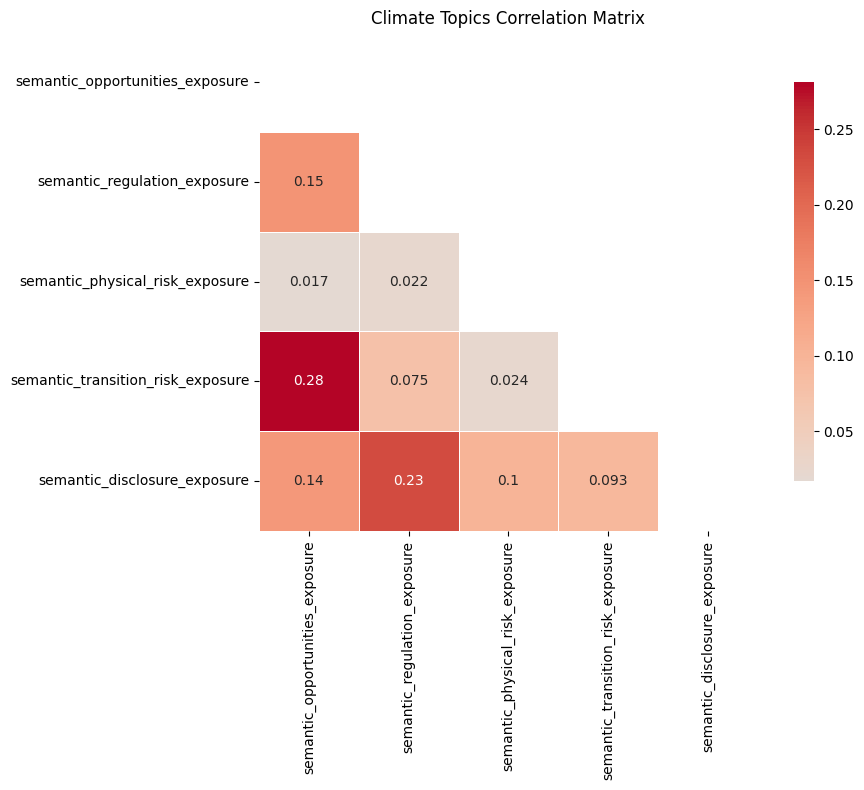


🎯 RELEVANCE SCORES:
  Mean relevance score: 0.445
  Median relevance score: 0.439
  Firm-quarters with scores: 9,317

🏛️ POLICY EVENT ANALYSIS:


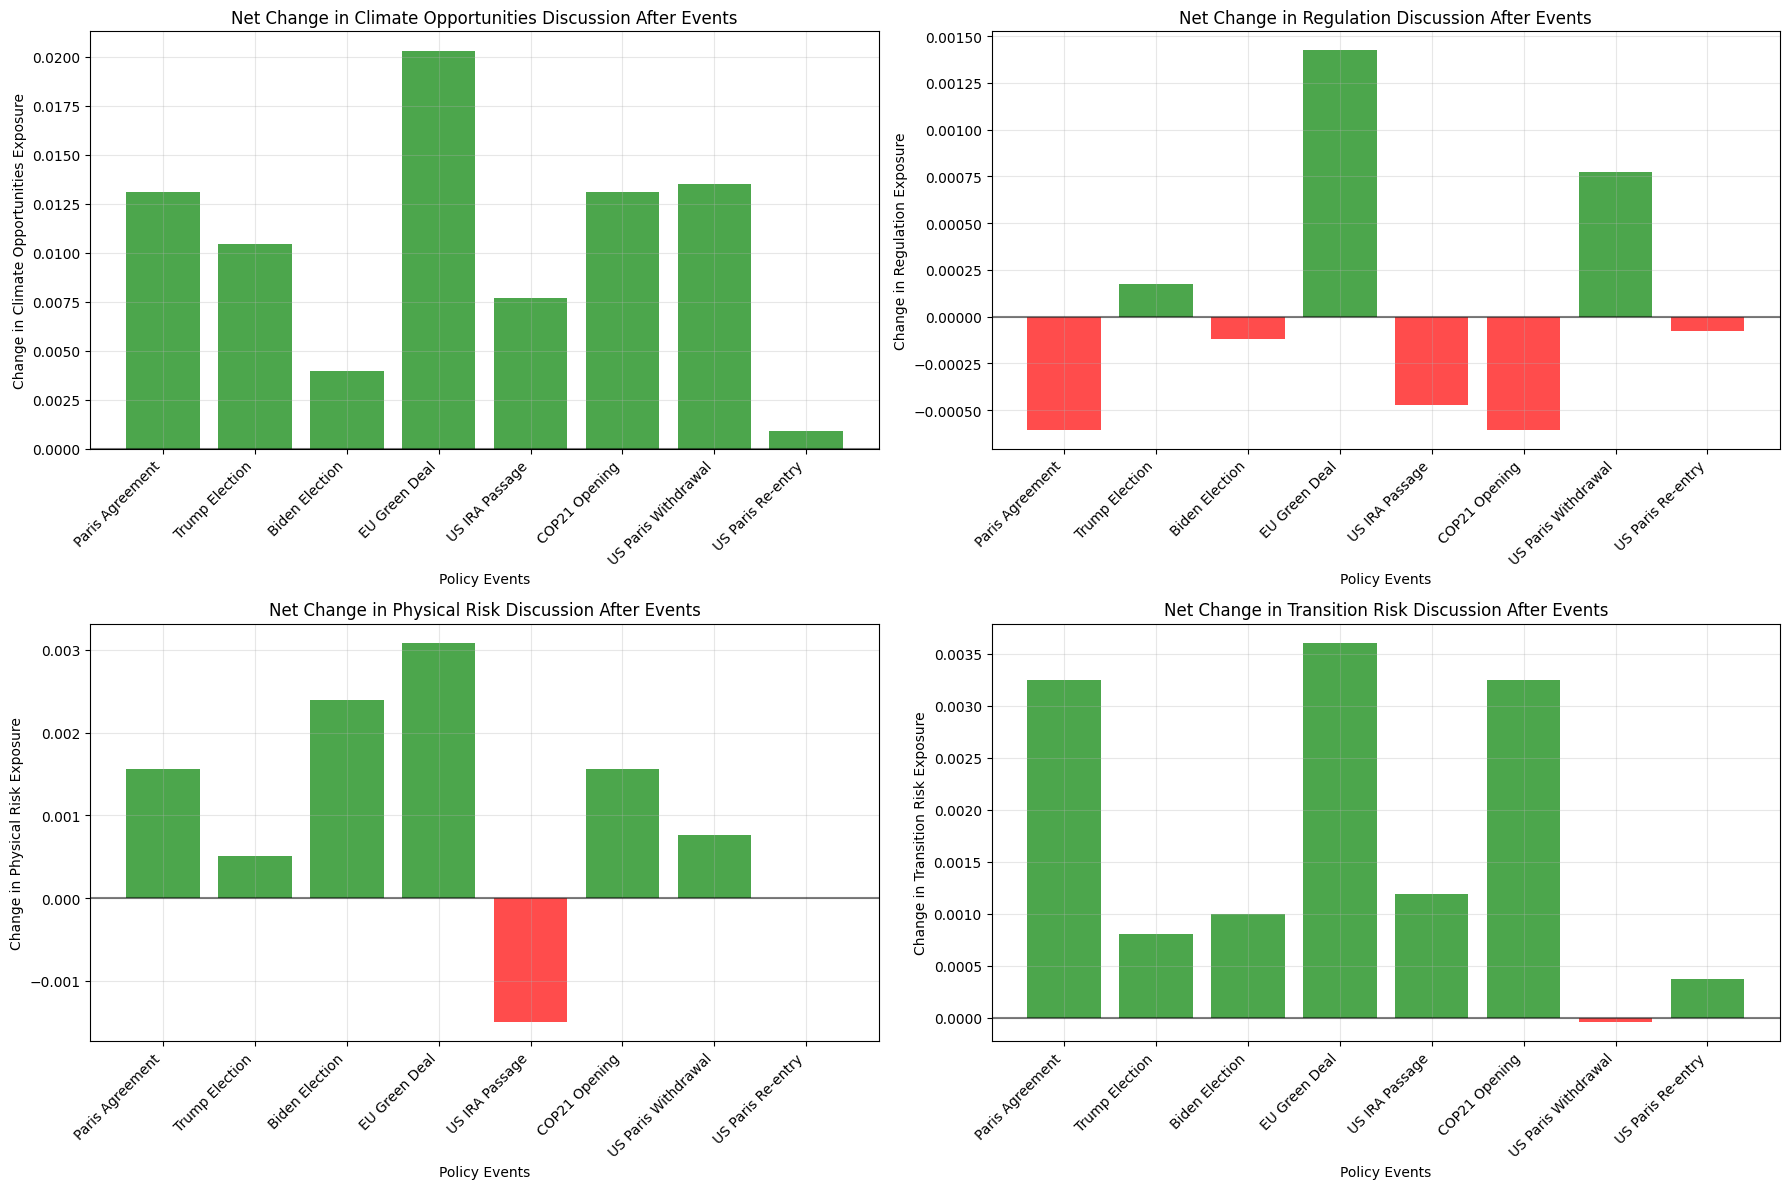


📊 CROSS-TOPIC EVENT IMPACT SUMMARY:
                   Topic  Avg_Change  Max_Positive_Change  \
0  Climate Opportunities      0.0104               0.0203   
1             Regulation      0.0001               0.0014   
2          Physical Risk      0.0010               0.0031   
3        Transition Risk      0.0017               0.0036   

   Max_Negative_Change Most_Impactful_Event  
0               0.0009        EU Green Deal  
1              -0.0006        EU Green Deal  
2              -0.0015        EU Green Deal  
3              -0.0000        EU Green Deal  


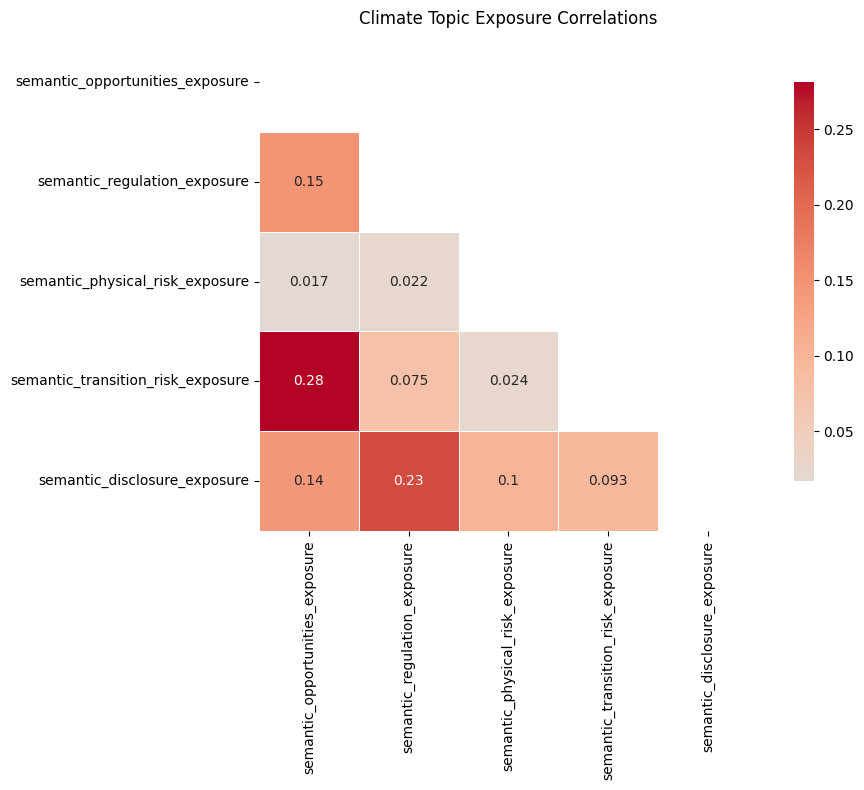

In [30]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# ==========================================
# 1. LOAD AND INSPECT DATA
# ==========================================

# Load the main dataset
data_path = "semantic_climate_panel.csv"
df = pd.read_csv(data_path)

print("🌱 SEMANTIC CLIMATE VARIABLES DATASET ANALYSIS")
print("=" * 50)

# Basic dataset info
print(f"📊 Dataset shape: {df.shape}")
print(f"📅 Time period: {df['year'].min()}-{df['year'].max()}")
print(f"🏢 Number of firms: {df['ticker'].nunique()}")
print(f"⏰ Number of quarters: {len(df.groupby(['year', 'quarter']))}")

# Data coverage
total_possible = df['ticker'].nunique() * len(df.groupby(['year', 'quarter']))
actual_with_calls = df['has_earnings_call'].sum()
coverage_rate = actual_with_calls / len(df)

print(f"\n📈 DATA COVERAGE:")
print(f"  Total possible firm-quarters: {len(df):,}")
print(f"  Firm-quarters with earnings calls: {actual_with_calls:,}")
print(f"  Coverage rate: {coverage_rate:.1%}")

# ==========================================
# 2. CLIMATE TOPIC VARIABLES ANALYSIS
# ==========================================

print(f"\n🔍 CLIMATE TOPIC VARIABLES:")

# Get climate topic variables
climate_vars = [col for col in df.columns if col.startswith('semantic_') and col.endswith('_exposure')]
policy_vars = [col for col in df.columns if col.startswith('policy_') and col.endswith('_attention')]

print(f"  Climate topics: {len(climate_vars)}")
print(f"  Policy topics: {len(policy_vars)}")

# Coverage (% of firm-quarters with any mention)
print(f"\n📋 TOPIC COVERAGE (% firm-quarters with mentions):")
for var in climate_vars:
    topic_name = var.replace('semantic_', '').replace('_exposure', '')
    coverage = (df[var] > 0).mean()
    mean_exposure = df[var].mean()
    print(f"  {topic_name:15}: {coverage:6.1%} coverage, {mean_exposure:6.4f} mean exposure")

# ==========================================
# 3. VISUALIZATION 1: TOPIC DISTRIBUTION
# ==========================================

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Climate Topic Exposure Distributions', fontsize=16)

for i, var in enumerate(climate_vars):
    row, col = i // 3, i % 3
    if row < 2 and col < 3:
        # Plot histogram of non-zero values
        non_zero_data = df[df[var] > 0][var]
        topic_name = var.replace('semantic_', '').replace('_exposure', '').title()
        
        axes[row, col].hist(non_zero_data, bins=30, alpha=0.7, edgecolor='black')
        axes[row, col].set_title(f'{topic_name}\n({len(non_zero_data)} non-zero obs)')
        axes[row, col].set_xlabel('Exposure Level')
        axes[row, col].set_ylabel('Frequency')
        
        # Add mean line
        if len(non_zero_data) > 0:
            mean_val = non_zero_data.mean()
            axes[row, col].axvline(mean_val, color='red', linestyle='--', 
                                 label=f'Mean: {mean_val:.3f}')
            axes[row, col].legend()

# Remove empty subplot
if len(climate_vars) < 6:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

# ==========================================
# 4. TIME TRENDS ANALYSIS
# ==========================================

print(f"\n📈 TIME TRENDS ANALYSIS:")

# Create quarterly aggregates
quarterly_data = df.groupby(['year', 'quarter'])[climate_vars + policy_vars].mean().reset_index()
quarterly_data['period'] = quarterly_data['year'].astype(str) + 'Q' + quarterly_data['quarter'].astype(str)

# Apply rolling average smoothing (4-quarter rolling window)
rolling_window = 4
for var in climate_vars + policy_vars:
    quarterly_data[f'{var}_smoothed'] = quarterly_data[var].rolling(window=rolling_window, center=True).mean()

# Plot time trends - Climate topics only
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Climate topics over time
ax.set_title('Climate Topic Exposure Over Time (4-Quarter Rolling Average)', fontsize=14)
for var in climate_vars:
    topic_name = var.replace('semantic_', '').replace('_exposure', '')
    ax.plot(quarterly_data.index, quarterly_data[f'{var}_smoothed'], 
            label=topic_name, linewidth=2.5)

ax.set_xlabel('Quarter')
ax.set_ylabel('Average Exposure')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

# Add quarter labels
quarter_labels = quarterly_data['period'][::4]  # Every 4th quarter
quarter_positions = range(0, len(quarterly_data), 4)

ax.set_xticks(quarter_positions)
ax.set_xticklabels(quarter_labels, rotation=45)

plt.tight_layout()
plt.show()

# Print smoothing information
print(f"\n📊 SMOOTHING INFO:")
print(f"Applied {rolling_window}-quarter rolling average to smooth time series")
print(f"Showing climate topic exposure trends only")

# ==========================================
# 5. CROSS-SECTIONAL ANALYSIS
# ==========================================

print(f"\n🏢 CROSS-SECTIONAL ANALYSIS:")

# Firm-level aggregates
firm_aggregates = df.groupby('ticker')[climate_vars].mean().reset_index()

# Top firms by climate engagement
print(f"\n🏆 TOP 10 FIRMS BY TOTAL CLIMATE EXPOSURE:")
firm_aggregates['total_climate_exposure'] = firm_aggregates[climate_vars].sum(axis=1)
top_firms = firm_aggregates.nlargest(10, 'total_climate_exposure')

for i, (_, row) in enumerate(top_firms.iterrows(), 1):
    print(f"  {i:2d}. {row['ticker']:6} - {row['total_climate_exposure']:.4f}")

# Correlation matrix
climate_corr = df[climate_vars].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(climate_corr, dtype=bool))
sns.heatmap(climate_corr, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Climate Topics Correlation Matrix')
plt.tight_layout()
plt.show()

# ==========================================
# 7. QUALITY METRICS ANALYSIS
# ==========================================

# Average relevance scores
if 'semantic_avg_relevance_score' in df.columns:
    avg_relevance = df[df['semantic_avg_relevance_score'] > 0]['semantic_avg_relevance_score']
    print(f"\n🎯 RELEVANCE SCORES:")
    print(f"  Mean relevance score: {avg_relevance.mean():.3f}")
    print(f"  Median relevance score: {avg_relevance.median():.3f}")
    print(f"  Firm-quarters with scores: {len(avg_relevance):,}")

# ==========================================
# 8. POLICY EVENT ANALYSIS
# ==========================================

print(f"\n🏛️ POLICY EVENT ANALYSIS:")

# Major climate policy events
events = {
    'Paris Agreement': '2015-12-12',
    'Trump Election': '2016-11-08',
    'Biden Election': '2020-11-07',
    'EU Green Deal': '2019-12-11',
    'US IRA Passage': '2022-08-16',
    'COP21 Opening': '2015-11-30',
    'US Paris Withdrawal': '2017-06-01',
    'US Paris Re-entry': '2021-01-20'
}

# Topics to analyze
climate_topics = ['semantic_opportunities_exposure', 'semantic_regulation_exposure', 'semantic_physical_risk_exposure', 'semantic_transition_risk_exposure']
topic_labels = ['Climate Opportunities', 'Regulation', 'Physical Risk', 'Transition Risk']

# Convert dates
df['date'] = pd.to_datetime(df['date'])

# Create analysis for each topic
all_event_analysis = {}

for topic in climate_topics:
    event_analysis = []
    
    for event_name, event_date in events.items():
        event_dt = pd.to_datetime(event_date)
        
        # Define windows around event
        pre_window = (df['date'] >= event_dt - pd.Timedelta(days=90)) & (df['date'] < event_dt)
        post_window = (df['date'] >= event_dt) & (df['date'] <= event_dt + pd.Timedelta(days=90))
        
        # Calculate average climate exposure before and after
        pre_avg = df[pre_window][topic].mean()
        post_avg = df[post_window][topic].mean()
        
        # Count observations
        pre_obs = len(df[pre_window])
        post_obs = len(df[post_window])
        
        event_analysis.append({
            'Event': event_name,
            'Date': event_date,
            'Pre_Avg_Exposure': pre_avg,
            'Post_Avg_Exposure': post_avg,
            'Change': post_avg - pre_avg,
            'Pre_Observations': pre_obs,
            'Post_Observations': post_obs
        })
    
    # Create event analysis DataFrame for this topic
    event_df = pd.DataFrame(event_analysis)
    event_df = event_df.dropna()  # Remove events with no data
    all_event_analysis[topic] = event_df


# Create net change comparison plot
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, (topic, topic_label) in enumerate(zip(climate_topics, topic_labels)):
    event_df = all_event_analysis[topic]
    
    if len(event_df) == 0:
        axes[idx].text(0.5, 0.5, f'No data for {topic_label}', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        continue
    
    # Net change from events
    x_pos = range(len(event_df))
    colors = ['green' if x > 0 else 'red' for x in event_df['Change']]
    
    axes[idx].bar(x_pos, event_df['Change'], color=colors, alpha=0.7)
    axes[idx].set_xlabel('Policy Events')
    axes[idx].set_ylabel(f'Change in {topic_label} Exposure')
    axes[idx].set_title(f'Net Change in {topic_label} Discussion After Events')
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(event_df['Event'], rotation=45, ha='right')
    axes[idx].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison across topics
print(f"\n📊 CROSS-TOPIC EVENT IMPACT SUMMARY:")
summary_data = []

for topic, topic_label in zip(climate_topics, topic_labels):
    event_df = all_event_analysis[topic]
    if len(event_df) > 0:
        avg_change = event_df['Change'].mean()
        max_positive = event_df['Change'].max()
        max_negative = event_df['Change'].min()
        most_impactful = event_df.loc[event_df['Change'].abs().idxmax(), 'Event']
        
        summary_data.append({
            'Topic': topic_label,
            'Avg_Change': avg_change,
            'Max_Positive_Change': max_positive,
            'Max_Negative_Change': max_negative,
            'Most_Impactful_Event': most_impactful
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(4))

# ==========================================
# 10. CORRELATION ANALYSIS
# ==========================================

# Calculate correlation matrix for climate variables
climate_corr = df[climate_vars].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(climate_corr, dtype=bool))  # Show only lower triangle

sns.heatmap(climate_corr, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Climate Topic Exposure Correlations')
plt.tight_layout()
plt.show()


In [ ]:
# ==========================================
# 11. SUMMARY STATISTICS TABLE
# ==========================================

print(f"\n📊 COMPREHENSIVE SUMMARY STATISTICS:")

# Create comprehensive summary table
summary_stats = []

for var in climate_vars + policy_vars:
    topic_name = var.replace('semantic_', '').replace('_exposure', '').replace('policy_', '')
    topic_name = topic_name.replace('_attention', '').title()
    
    # All observations
    all_data = df[var]
    # Non-zero observations
    nonzero_data = df[df[var] > 0][var]
    
    stats = {
        'Topic': topic_name,
        'Total_Obs': len(all_data),
        'NonZero_Obs': len(nonzero_data),
        'Coverage_%': (len(nonzero_data) / len(all_data) * 100),
        'Mean_All': all_data.mean(),
        'Mean_NonZero': nonzero_data.mean() if len(nonzero_data) > 0 else 0,
        'Std_NonZero': nonzero_data.std() if len(nonzero_data) > 0 else 0,
        'Median_NonZero': nonzero_data.median() if len(nonzero_data) > 0 else 0,
        'Max': all_data.max(),
        'P95': all_data.quantile(0.95),
        'P75': all_data.quantile(0.75)
    }
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print(summary_df.round(4))

# Save summary statistics
summary_df.to_csv('climate_topic_summary_statistics.csv', index=False)
print(f"\n💾 Summary statistics saved to 'climate_topic_summary_statistics.csv'")

print(f"\n🎉 ANALYSIS COMPLETE!")
print(f"📊 Dataset contains {len(df):,} observations across {df['ticker'].nunique()} firms")
print(f"📅 Time period: {df['year'].min()}-{df['year'].max()}")
print(f"🏢 Average observations per firm: {len(df)/df['ticker'].nunique():.1f}")